In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [166]:
real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

img_shape = (1, 28, 28)
label shape = torch.Size([])
img_shape after squeeze = (28, 28)


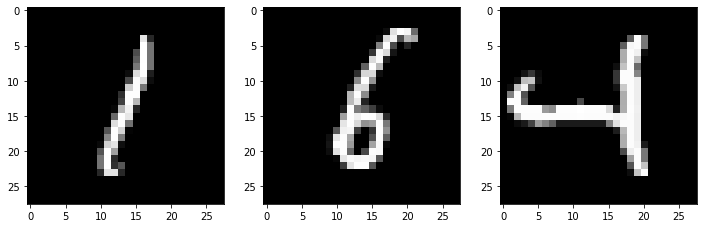

In [102]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'label shape = {labels[0].shape}')

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')

img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.imshow(img, cmap='gray')
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray');

In [103]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], f"images/{batches_done}.png", nrow=5, normalize=True)

In [104]:
#y = sin(x)/x - x/10
def my_func(x):
    return (torch.sin(x)/x) - (x/10)

In [184]:
train_data = torch.zeros((1024, 2))

In [185]:
train_data[:, 0] = 30 * torch.rand(1024) - 15

In [186]:
train_data[:, 1] = my_func(train_data[:, 0])

In [187]:
train_labels = torch.zeros(1024)

In [188]:
train_set = [(train_data[i], train_labels[i]) for i in range(1024)]

In [189]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [207]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, x):
        output = self.model(x)
        return output

In [208]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [213]:
n_epochs = 20  # количество эпох
lr = 0.002  # шаг обучения

batch_size = 32  # размер батча

In [214]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [235]:
d_loss_history = []
g_loss_history = []

[Epoch 19/20] [Batch 22/32]|[D loss: 0.7430170178413391] [G loss: 0.741740882396698]


<Figure size 432x288 with 0 Axes>

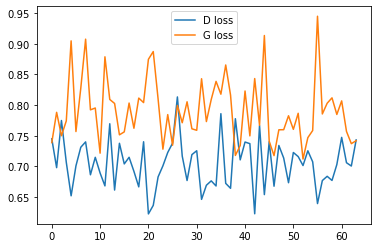

In [236]:
import matplotlib.patches as mpatches


for epoch in range(n_epochs):
    for i, (real_samples, _) in enumerate(train_loader):
        
        # Данные для обучения дискриминатора
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device) #real_samples_labels
        #latent_space_samples = torch.randn((batch_size, 2))
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)
        
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 2))).to(device)
        gen_z = generator(z)
        
        discriminator.zero_grad()
        
        real_pred = discriminator(real_samples)
        d_real_loss = adversarial_loss(real_pred, valid)
        fake_pred = discriminator(gen_z)
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward(retain_graph=True)

        optimizer_D.zero_grad()
        optimizer_D.step()

        fake_pred = discriminator(gen_z)
        g_loss = adversarial_loss(fake_pred, valid)
        g_loss.backward(retain_graph=True)
        
        optimizer_G.zero_grad()
        optimizer_G.step()

        batches_done = epoch * len(train_loader) + i
            
        if batches_done % 10 == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()         